In [59]:
from transformers import AutoTokenizer, BertForQuestionAnswering, BertModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Load model and retrieve attention weights

from bertviz import head_view, model_view
# from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, BertForQuestionAnswering, AutoModel

### Getting Sentence embeddings from "all-mpnet-base-v2" and calculating cosine similarity

In [60]:
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
question = "he is a good man"
text = "he is a good man"
sentences = ["he is a good man", "he is a great man"]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print('Sentence Embeddings:', sentence_embeddings)
print('Cosine Similarity from embeddings generated by the model: {:4f}'.format(torch.cosine_similarity(sentence_embeddings[0].unsqueeze(0), sentence_embeddings[1].unsqueeze(0)).item()))

Sentence Embeddings: tensor([[ 0.0314,  0.0596,  0.0288,  ...,  0.0033,  0.0556,  0.0068],
        [ 0.0211,  0.0423,  0.0354,  ...,  0.0096,  0.0508, -0.0001]])
Cosine Similarity from embeddings generated by the model: 0.884947


### Visualising attentions in "all-mpnet-base-v2" while ignoring \<s\>

In [72]:
model_version = 'sentence-transformers/all-mpnet-base-v2'
model = AutoModel.from_pretrained(model_version, output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_version)

question = "he is a good man"
text = "capital of france is paris"

inputs = tokenizer(question, text, return_tensors='pt')

input_ids = inputs['input_ids']
attention = model(input_ids)[-1]

input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [73]:
ticks = []
for j in range(len(inputs.input_ids)):
    print(f'Sentence {j+1}')
    for i in range(len(inputs.input_ids[j])):
        print(inputs.input_ids[0][i], ':', tokenizer.decode(inputs.input_ids[0][i]))
        ticks.append(tokenizer.decode(inputs.input_ids[0][i]))

Sentence 1
tensor(0) : <s>
tensor(2006) : he
tensor(2007) : is
tensor(1041) : a
tensor(2208) : good
tensor(2162) : man
tensor(2) : </s>
tensor(2) : </s>
tensor(3011) : capital
tensor(2001) : of
tensor(2609) : france
tensor(2007) : is
tensor(3004) : paris
tensor(2) : </s>


In [74]:
attention_tensors = []

for tensor in model(input_ids).attentions:
    attention_tensors.append(tensor.detach().numpy())

attentions_temp = torch.tensor(np.array(attention_tensors))
print(attentions_temp.shape)

torch.Size([12, 1, 12, 14, 14])


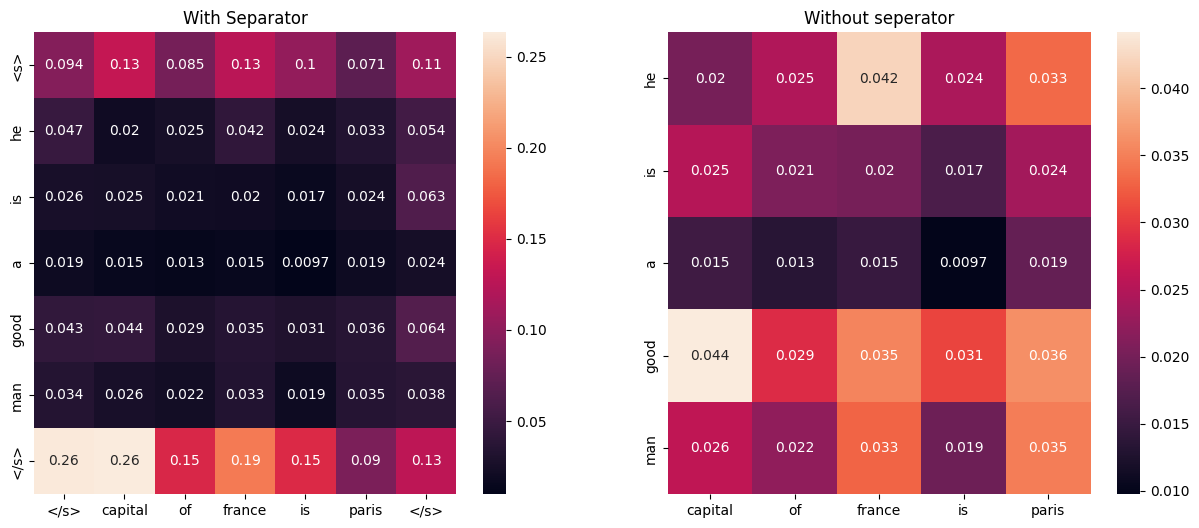

In [75]:
sentence1_len = len(question.split(" "))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("With Separator")
sns.heatmap(attentions_temp.mean(axis=2)[-1][0].T[0:sentence1_len+2,sentence1_len+2:] ,xticklabels = ticks[sentence1_len+2:] , yticklabels = ticks[0:sentence1_len+2], annot=True)
plt.subplot(1, 2, 2)
plt.title("Without seperator")
sns.heatmap(attentions_temp.mean(axis=2)[-1][0].T[1:sentence1_len+1,sentence1_len+3:-1] ,xticklabels = ticks[sentence1_len+3:-1] , yticklabels = ticks[1:sentence1_len+1], annot=True)
plt.show()

In [76]:
print(attentions_temp.mean(axis=2)[-1][0].T[0:sentence1_len+2,sentence1_len+2:])

tensor([[0.0944, 0.1324, 0.0852, 0.1262, 0.1032, 0.0712, 0.1102],
        [0.0467, 0.0201, 0.0247, 0.0421, 0.0244, 0.0333, 0.0539],
        [0.0263, 0.0251, 0.0208, 0.0201, 0.0165, 0.0237, 0.0630],
        [0.0190, 0.0155, 0.0134, 0.0148, 0.0097, 0.0187, 0.0239],
        [0.0426, 0.0442, 0.0288, 0.0353, 0.0308, 0.0362, 0.0644],
        [0.0338, 0.0259, 0.0222, 0.0329, 0.0194, 0.0348, 0.0377],
        [0.2616, 0.2635, 0.1473, 0.1922, 0.1493, 0.0900, 0.1278]])


In [77]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [78]:

import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
 
 
def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)
 
 
def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
        Select only those subword token outputs that belong to our word of interest
        and average them."""
    with torch.no_grad():
        output = model(**encoded)
 
     # Get all hidden states
    states = output.hidden_states
     # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
     # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]
 
    return word_tokens_output.mean(dim=0)
 
 
def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
        that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
     # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
 
    return get_hidden_states(encoded, token_ids_word, model, layers)
 
 
def main(layers , sent1 , sent2):
    # Use last four layers by default
    layers = [-4, -3, -2, -1] if layers is None else layers
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

    sent1_embeddings = []
    sent2_embeddings = []
    sent1 = sent1
    sent2 = sent2
    for w in sent1.split(" "):
        sent1_embeddings.append(get_word_vector(sent1, get_word_idx(sent1, w), tokenizer, model, layers))
    for w in sent2.split(" "):
        sent2_embeddings.append(get_word_vector(sent2 , get_word_idx(sent2, w), tokenizer, model, layers))
    # idx = get_word_idx(sent, "cookies")

    # word_embedding = get_word_vector(sent, idx, tokenizer, model, layers)
     
    return sent1_embeddings, sent2_embeddings 


In [79]:
sent1 = question
sent2 = text
s1 , s2 = main(None , sent1 , sent2)
sentence1 = sent1.split(" ")
sentence2 = sent2.split(" ")
for idx1 , v1 in enumerate(s1):
    for idx2 , v2 in enumerate(s2):
        print('{} ~ {} ; Cosine Distance: {:5f}' .format(sentence1[idx1], sentence2[idx2], torch.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()))

he ~ capital ; Cosine Distance: 0.708065
he ~ of ; Cosine Distance: 0.694814
he ~ france ; Cosine Distance: 0.730278
he ~ is ; Cosine Distance: 0.737584
he ~ paris ; Cosine Distance: 0.751316
is ~ capital ; Cosine Distance: 0.649755
is ~ of ; Cosine Distance: 0.717359
is ~ france ; Cosine Distance: 0.727070
is ~ is ; Cosine Distance: 0.777346
is ~ paris ; Cosine Distance: 0.719398
a ~ capital ; Cosine Distance: 0.580931
a ~ of ; Cosine Distance: 0.635715
a ~ france ; Cosine Distance: 0.658327
a ~ is ; Cosine Distance: 0.657031
a ~ paris ; Cosine Distance: 0.643920
good ~ capital ; Cosine Distance: 0.608007
good ~ of ; Cosine Distance: 0.660477
good ~ france ; Cosine Distance: 0.688603
good ~ is ; Cosine Distance: 0.678981
good ~ paris ; Cosine Distance: 0.688645
man ~ capital ; Cosine Distance: 0.647123
man ~ of ; Cosine Distance: 0.690453
man ~ france ; Cosine Distance: 0.701956
man ~ is ; Cosine Distance: 0.688597
man ~ paris ; Cosine Distance: 0.777500


In [80]:
attention_last = attentions_temp.mean(axis=2)[-1][0].T[0:sentence1_len+2,sentence1_len+2:]
sum = 0
num_non_sep = 0
print(sentence1)
print(sentence2)
for r in range(attention_last.shape[0]-1):
    if r == 0 or r == len(attention_last)-1:
        continue
    max_idx = np.argmax(attention_last[r-1])
    if max_idx == len(attention_last[r-1])-1:
        print("{} , {} , [SEP]".format(r , sentence1[r-1]))      
        continue 
    else:
        print("{} : {} : {} : {}".format(r , sentence1[r-1] , sentence2[max_idx] , torch.cosine_similarity(s1[r-1].unsqueeze(0), s2[max_idx].unsqueeze(0))))
        num_non_sep += 1
    sum+=torch.cosine_similarity(s1[r-1].unsqueeze(0), s2[max_idx].unsqueeze(0))


print(sum)
print("Score: ",sum/len(question.split(" ")))
print("Score without sep: ", sum / num_non_sep)

['he', 'is', 'a', 'good', 'man']
['capital', 'of', 'france', 'is', 'paris']
1 : he : of : tensor([0.6948])
2 , is , [SEP]
3 , a , [SEP]
4 , good , [SEP]
5 , man , [SEP]
tensor([0.6948])
Score:  tensor([0.1390])
Score without sep:  tensor([0.6948])
